# Multi linear model

Single shot multi linear model

In [111]:
import time

import pandas as pd
import tensorflow as tf

from window import WindowGenerator
import utils

In [112]:
def train_case(case_df, model, in_width, out_steps, max_epochs):
    """ Train model for given case df. Currently uses 20% of data for validation and 80% for training. """
    
    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = utils.train_test_val_split(case_df, test_size=0, val_size=0.2)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Dataset

In [113]:
case_1 = pd.read_csv("../datasets/case_1.csv", index_col='Time')
case_2 = pd.read_csv("../datasets/case_2.csv", index_col='Time')
case_3 = pd.read_csv("../datasets/case_3.csv", index_col='Time')
case_4 = pd.read_csv("../datasets/case_4.csv", index_col='Time')
case_5 = pd.read_csv("../datasets/case_5.csv", index_col='Time')

In [114]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

In [115]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Model creation

In [116]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 20
features_size = len(label_columns)

print(f"Using {IN_WIDTH*5//60}min {IN_WIDTH*5 % 60}s of data to predict {OUT_STEPS*5//60}min {IN_WIDTH*5 % 60}s into de future.")

Using 1min 30s of data to predict 1min 30s into de future.


In [117]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(10, activation='relu'), # 512
    # Dropout
    # tf.keras.layers.Dropout(rate=0.5),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*features_size,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, features_size])
])

In [118]:
multi_linear_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [119]:
exec_times = {}

In [120]:
results = {}

## Case 2

In [121]:
start_t = time.time()

window, history = train_case(case_2, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

exec_times['case_2'] = time.time() - start_t

2022-10-02 21:24:19.705278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-02 21:24:20.105468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [122]:
multi_linear_model.build(input_shape=window.example[0].shape)
multi_linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 272)            0         
                                                                 
 dense_6 (Dense)             (None, 1, 10)             2730      
                                                                 
 dense_7 (Dense)             (None, 1, 2448)           26928     
                                                                 
 reshape_3 (Reshape)         (None, 18, 136)           0         
                                                                 
Total params: 29,658
Trainable params: 29,658
Non-trainable params: 0
_________________________________________________________________


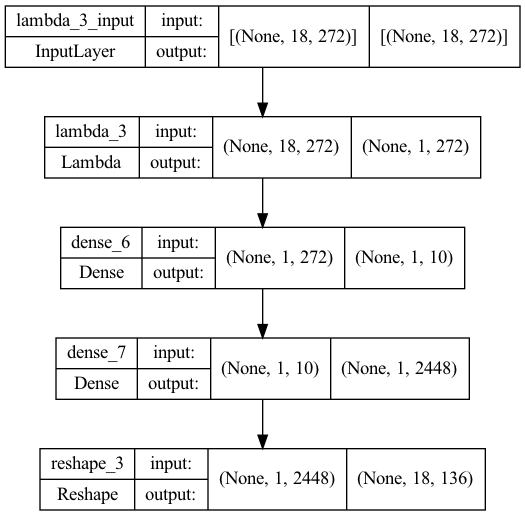

In [123]:
tf.keras.utils.plot_model(multi_linear_model, "../plots/models/multi_lineal.png", show_shapes=True)

label_col_index 135
label_col_index 135
label_col_index 135


2022-10-02 21:24:28.383935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


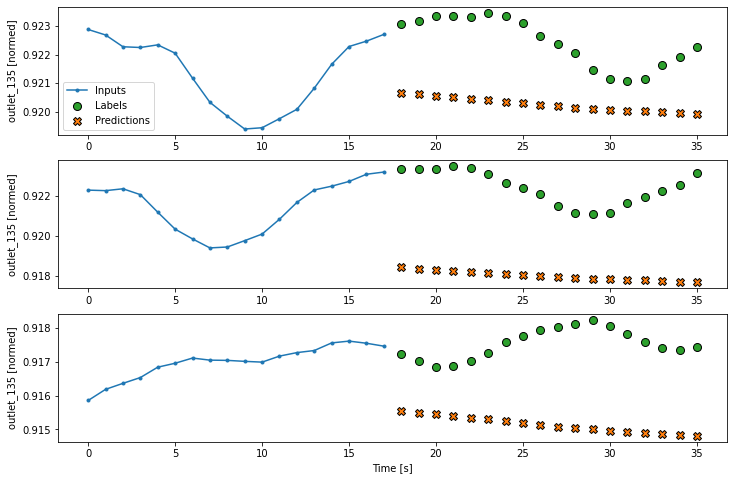

In [124]:
window.plot(multi_linear_model, plot_col="outlet_135")

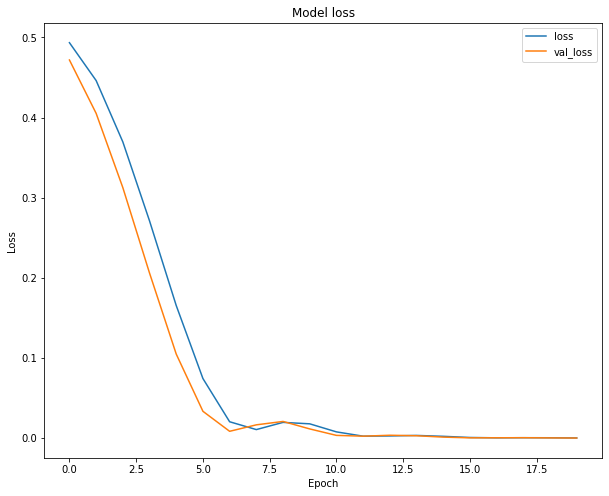

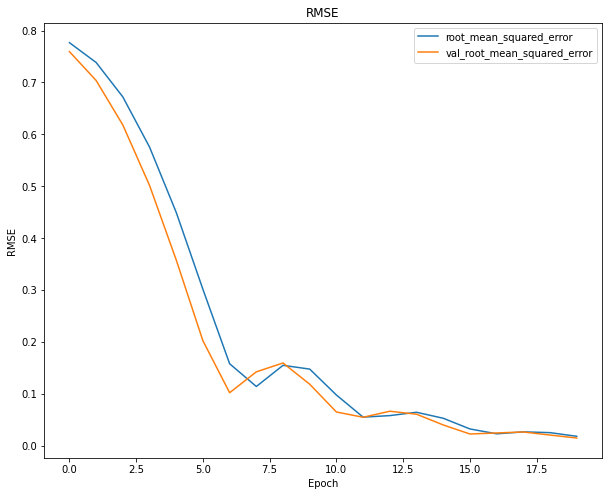

In [125]:
utils.plot_losses(history=history)

In [126]:
results['case_2'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 3

In [127]:
start_t = time.time()

window, history = train_case(case_3, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

exec_times['case_3'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


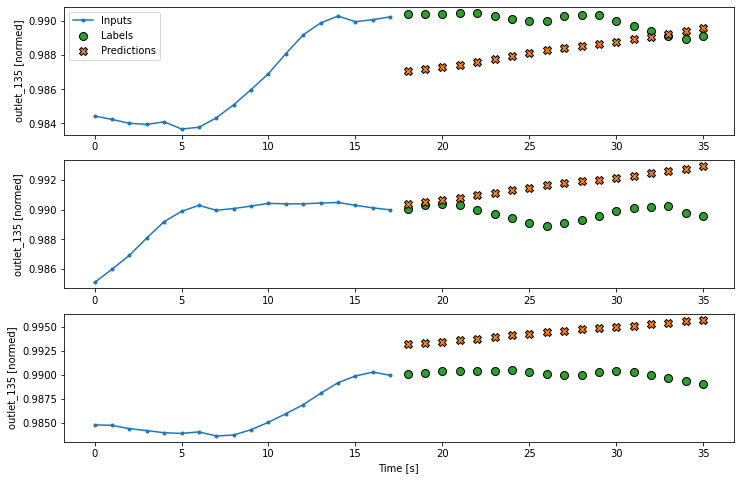

In [128]:
window.plot(multi_linear_model, plot_col="outlet_135")

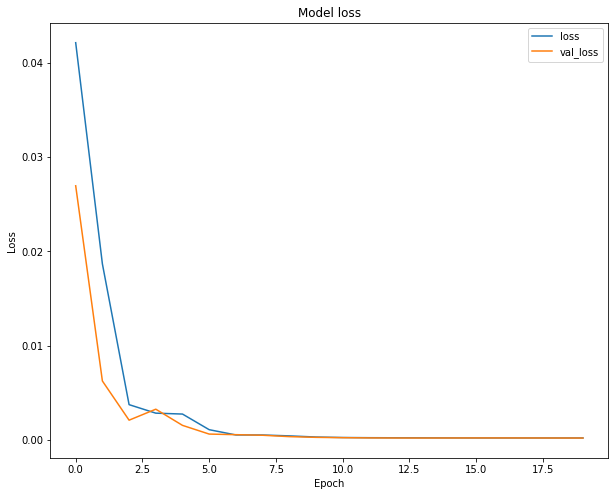

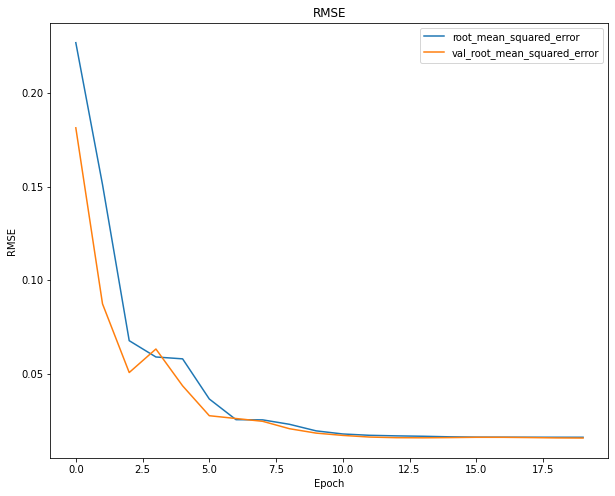

In [129]:
utils.plot_losses(history=history)

In [130]:
results['case_3'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 4

In [131]:
start_t = time.time()

window, history = train_case(case_4, multi_linear_model, IN_WIDTH, OUT_STEPS, MAX_EPOCHS)

exec_times['case_4'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


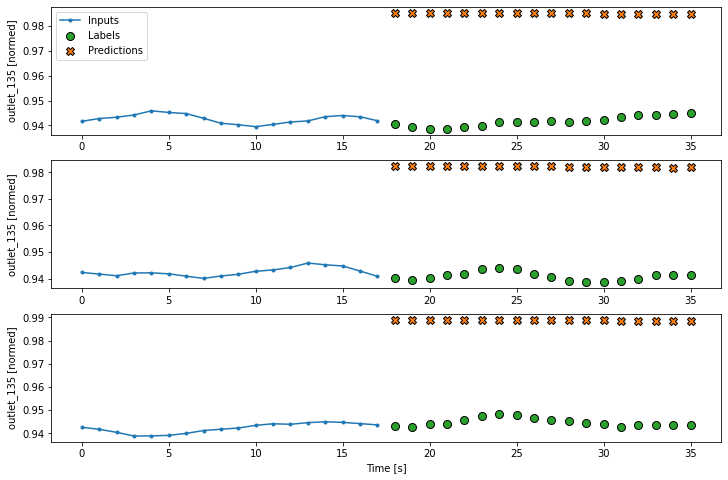

In [132]:
window.plot(multi_linear_model, plot_col="outlet_135")

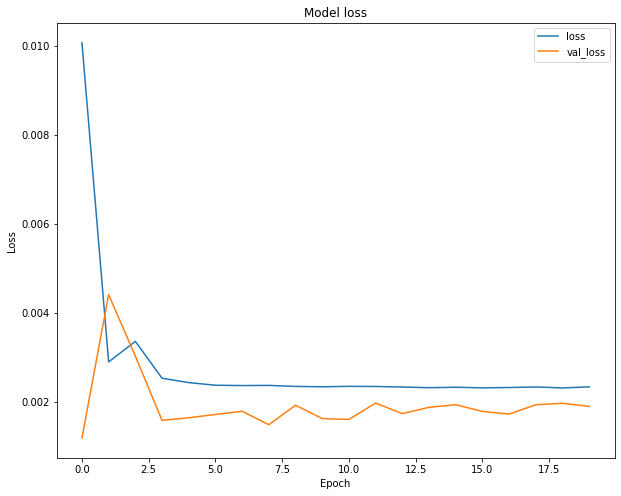

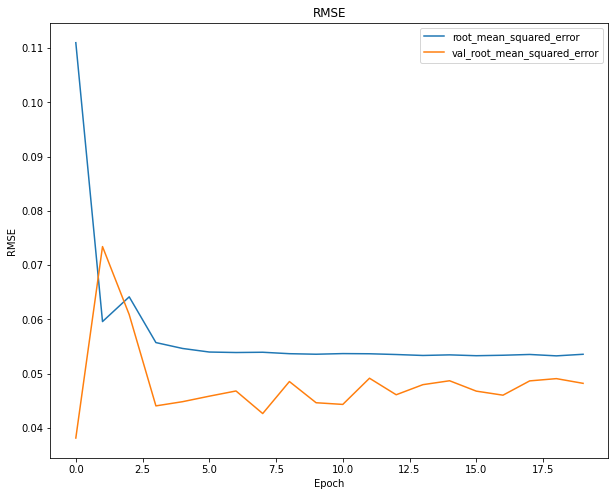

In [133]:
utils.plot_losses(history=history)

In [134]:
results['case_4'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 5

In [135]:
start_t = time.time()

window, history = train_case(
    case_df=case_5,
    model=multi_linear_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_5'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


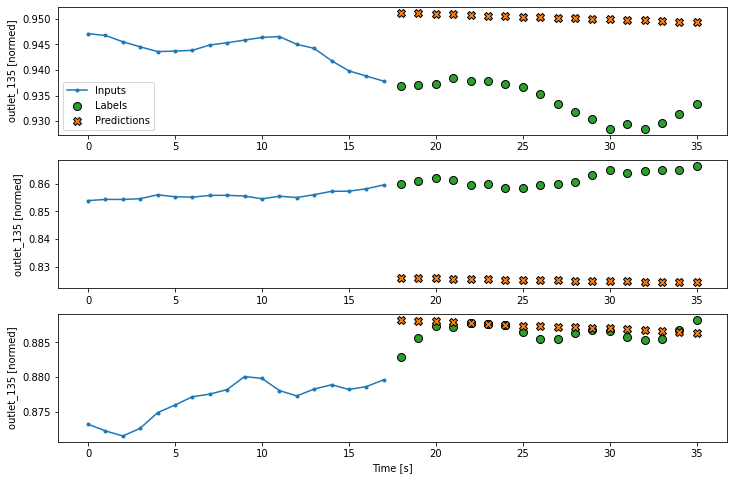

In [136]:
window.plot(multi_linear_model, plot_col="outlet_135")

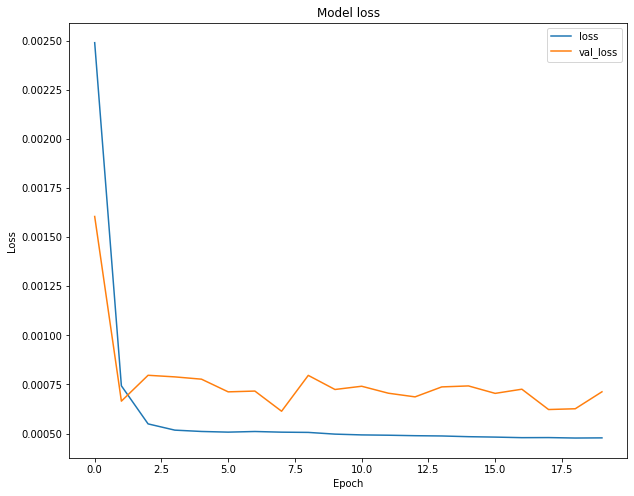

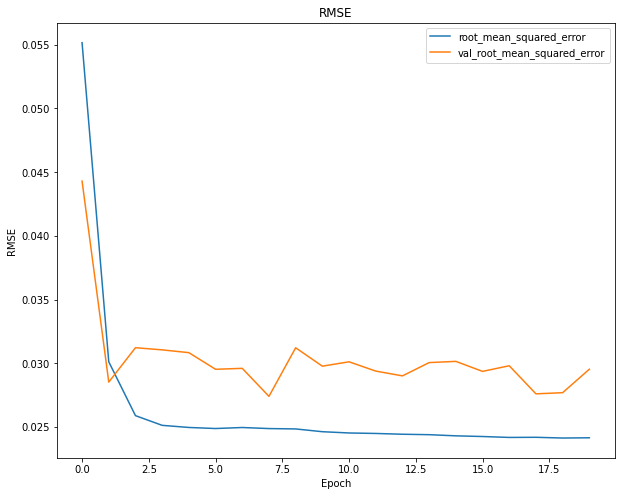

In [137]:
utils.plot_losses(history=history)

In [138]:
results['case_5'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 1 (Testing)

In [139]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

In [140]:
window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=outlets
)

test_results = multi_linear_model.evaluate(window.train)

5/5 [==============================] - 0s 8ms/step - loss: 0.0225 - root_mean_squared_error: 0.1660


## Results

In [141]:
results['test'] = {
    'loss': test_results[0],
    'rmse': test_results[1]
}

In [151]:
pd.DataFrame(results).transpose().round(4)

,loss,rmse,val_loss,val_rmse
case_2,0.0003,0.0185,0.0002,0.0152
case_3,0.0002,0.0160,0.0002,0.0156
case_4,0.0023,0.0536,0.0019,0.0482
case_5,0.0005,0.0242,0.0007,0.0295
test,0.0225,0.1660,NaN,NaN


In [148]:
exec_times_df = pd.DataFrame().from_dict(exec_times, orient='index', columns=['Time'])
exec_times_df.round(2)

,Time
case_2,9.01
case_3,9.21
case_4,9.57
case_5,11.10


In [152]:
print("Total training time: %.2fs" % exec_times_df['Time'].sum())

Total training time: 38.88s
